In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 2
(11 points)

**a)** In this problem we will study a **structural time series** model.
$$
    \begin{cases} \alpha_t = T \alpha_{t-1} + R \eta_t, & \eta_t \sim \mathcal{N}(0,Q), \\ y_t = Z \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,H), \end{cases}
$$
where $\alpha_t$ contains a trend and seasonal part.
The trend in this model is **linear** but the seasonality is unknown.
We let the variances of the model be $\sigma_{\mu}^2 = 0.1^2$, $\sigma_{\gamma}^2 = 0.1^2$, and $\sigma_{\varepsilon}^2 = 1$.

The data file `data_problem2.csv` contains a sequence of observations from this model over a few years. Using this data you are tasked to do the following:

1. Look at the provided data and find the seasonality $s$.
2. Setup the complete model by writing down the matrices $T$, $R$, $Q$, $Z$, and $H$. Also specify your hidden states $\alpha_t$. Remember to motivate your choices of matrices.
3. Set up the mean vector of the initial distribution such that 
    * The trend component starts at the first observation,
    * The slope of the trend is _a priori_ zero in expectation,
    * The initial mean of all states related to the seasonal component are zero.
4. Set up the initial covariance matrix as a diagonal matrix with 100 on the diagonal.

<div style="text-align: right"> (4p) </div>

In [2]:
data = pd.read_csv('data_problem2.csv',header=0)
y = data['Data'].values
u = data['Dates'].values

from tssltools import LGSS

**Solution:**

[50.1012644  50.54930816 48.56720102 48.27293617 48.19064665 47.509812
 47.11368354 46.39558782 46.71347097 45.99181848 46.34488156 46.17362559
 46.20419207 45.87863177 46.80555568 46.59578129 46.65919836 46.60038231
 47.92357217 47.7419091  48.37717956 49.13881944 49.13444967 49.51604609
 50.43548537 50.15600977 50.48842373 50.66835841 50.94851877 50.95775625
 51.00314446 50.65423242 50.83023203 50.27702801 49.62812419 49.53160717
 49.73076085 49.29359378 48.91693186 48.26511641]


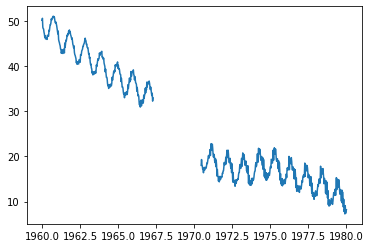

In [4]:
plt.plot(u,y)
print(y[:40])

**(1)**: The plot shows a clear seasonal part in the model. The seasonality can be counted as the number of observation from first peak value to the onservation before the second peak value. In total is 24 observation, so s = 29.

___

In [10]:
s = 29
# matrix for mu
T_mu = np.matrix([[2, -1],[1, 0]])
R_mu = np.matrix([[1],[0]])
Z_mu = np.matrix([1, 0]) 
# matrix for gamma
T_gamma = np.eye(s-1, k = -1)
T_gamma[0,:] = -1
R_gamma = np.zeros((s-1,1))
R_gamma[0,0] = 1
Z_gamma = np.zeros((1,s-1))
Z_gamma[0,0] = 1
# mix them together
from scipy.linalg import block_diag
T = block_diag(T_mu,T_gamma)
R = block_diag(R_mu,R_gamma)
Z = np.concatenate((Z_mu,Z_gamma),1)
Q = np.array([[0.1**2, 0.], [0., 0.1**2]])
H = np.array([1])
#
a1 = np.zeros((s-1+2,1))
# initial state : first two elements should be equal
# see course notes L5 a
a1[0:2,0] = (y[0],y[0])
P1 = np.eye(s-1+2)*100
print(T.shape)

(30, 30)


**b)** When performing inference in a structural time series model we are interested in the distribution of the hidden states given the data. You find your implementation of the Kalman filter but unfortunately some parts of the code is missing, to fix this you should do the following:

1. Derive the conditional distribution of $\alpha_{t+1} \mid \alpha_t, y_{1:t}$. **distribution**  
2. Use these results to compelte the implementation of the Kalman filter below. 

<div style="text-align: right"> (3p) </div>

$\alpha_{t+1}$ is Normal distribution, mean and variance can be calculated from $\alpha_t$ 

In [7]:
print(Z.shape)

(1, 30)


**Solution:**

In [8]:
from tssltools import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params() 

    for t in range(n):
        # Time update (predict)
        if t == 0:  
            alpha_pred[:, 0, 0] = np.squeeze(a1) 
            P_pred[:, :, 0] = P1
        else:
            ##############################
            # ADD CODE HERE:
            alpha_pred[:,:,t] = T@alpha_filt[:,:,t-1]
            P_pred[:,:,t] = T@P_filt[:,:,t-1]@T.T+R@Q@R.T
            ###############################

        # Compute prediction of current output
        y_pred[t] = Z @ alpha_pred[:, :, t]
        F_pred[t] = Z @ P_pred[:, :, t] @ Z.T + H

        # Measurement update
        if np.isnan(y[t]):
            alpha_filt[:, :, t] = alpha_pred[:, :, t].copy()
            P_filt[:, :, t] = P_pred[:, :, t].copy()
        else:
            K = P_pred[:, :, t] @ Z.T / F_pred[t]
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K * (y[t] - y_pred[t])
            P_filt[:, :, t] = (np.identity(d) - K @ Z) @ P_pred[:, :, t]

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

___

**c)** As you look into the data you may have noticed that some data-points are missing, you are interested in trying to estimate this missing sequence.

For this task you should do the following:

1. Run the Kalman filter and Kalman smoother on the data.
2. Generate a plot showing the data, the filtered estimates $\mathbb{E}[Z \alpha_t \mid y_{1:t}]$ and the smoothed estimates $\mathbb{E}[Z \alpha_t \mid y_{1:n}]$ for all $t$.
3. For both the filter and smoothing estiamtes you should add $\pm 1$ standard deviation.
4. Discuss the difference between the estimates (both mean and standard deviation) of the filter and the smoother.

<div style="text-align: right"> (4p) </div>

**Solution:**

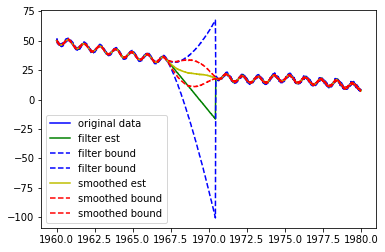

In [9]:
from tssltools import LGSS, kalman_smoother
model = LGSS(T, R, Q, Z, H, a1, P1)
kf = kalman_filter(y,model)
sm_res = kalman_smoother(y,model,kf)

v = sm_res.V
m = sm_res.alpha_sm

# note: Answer below are refered to teacher's explanation not directly copy from his answer (there is no answer)


# here we need to have state mean and variance first,
# for mean is just Z @ mean(alpha_t)
# for variance we need Z @ var(alpha_t) @ Z.T

#filter
# calculate all mean value of Z@ alpha_t
z_alphat_mean = np.squeeze(np.array([Z@kf.alpha_filt[:,:,x] for x in np.arange(len(u))]))
# calculate all variance value of Z@ alpha_t
z_alphat_var = np.squeeze(np.array([Z@kf.P_filt[:,:,x]@Z.T for x in np.arange(len(u))]))

#smoothed
# The different thing compared with the lab is:
# in the lab we are asked to perform st which is the sum of mu_t and gamma_t
# These two things are mentioned in  the Lecture 5 and Seminar that only the first row of each part (trend and seasonal) are under consideration
# But here we need alpha which would refer to all the value in the vector

# calculate all mean value of Z@ alpha_t
sz_alphat_mean = np.squeeze(np.array([Z@m[:,:,x] for x in np.arange(len(u))]))
# calculate all variance value of Z@ alpha_t
sz_alphat_var = np.squeeze(np.array([Z@v[:,:,x]@Z.T for x in np.arange(len(u))]))

# The results here can be understanded as following:
# Z@alpha_t in our model is quite close to y (only missing a error term), so we make comparasion between original data 
# and estimated data from both filter and smoother

plt.plot(u,y,c='b',label='original data')
plt.plot(u,z_alphat_mean,c='g',label='filter est')
plt.plot(u,z_alphat_mean+np.sqrt(z_alphat_var),'--',c='b',label = 'filter bound')
plt.plot(u,z_alphat_mean-np.sqrt(z_alphat_var),'--',c='b',label = 'filter bound')
plt.plot(u,sz_alphat_mean,c='y',label = 'smoothed est')
plt.plot(u,sz_alphat_mean-np.sqrt(sz_alphat_var),'--',c='r',label = 'smoothed bound')
plt.plot(u,sz_alphat_mean+np.sqrt(sz_alphat_var),'--',c='r',label = 'smoothed bound')
plt.legend()
plt.show()


In [ ]:
#Answer for question4 is just simply make some comparasion